In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [44]:
df_train = pd.read_csv('./dataset/train.csv')
df_test = pd.read_csv('./dataset/test.csv')
df_target = pd.read_csv('./dataset/sample_submission.csv')

In [45]:
df_test.fillna("", inplace=True)
df_test['text'] = df_test['keyword'] + " "+df_test['location'] + " "+df_test['text']
df_train.fillna("", inplace=True)
df_train['text'] = df_train['keyword'] + " "+df_train['location'] + " "+df_train['text']

In [46]:

df_test = pd.merge(df_test, df_target, on='id')
df = pd.concat([df_train, df_test], axis=0)
df_train.shape, df_test.shape, df_target.shape, df.shape

((7613, 5), (3263, 5), (3263, 2), (10876, 5))

In [49]:
df_train.sample()

,id,keyword,location,text,target
875,1269,blood,???,blood ??? Private thirsty night?SAD BLOOD ROCK...,1


In [50]:
df_test.sample()

,id,keyword,location,text,target
2485,8303,rubble,UberlÌ¢ndia - MG - Brasil,rubble UberlÌ¢ndia - MG - Brasil China's Stock...,0


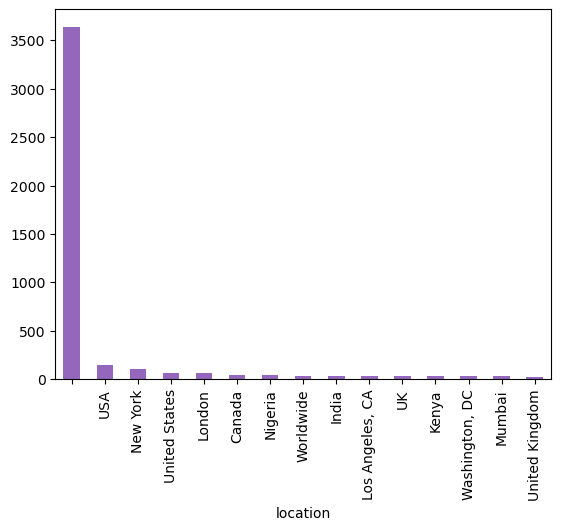

In [51]:
color = sns.color_palette()[4]
df['location'].value_counts()[:15].plot(kind='bar', color=color);

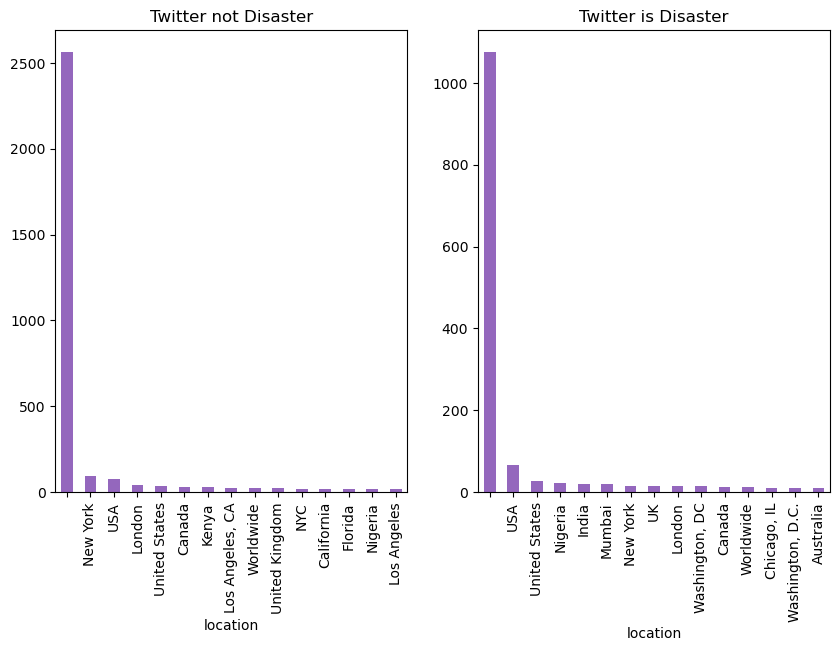

In [52]:
plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
plt.title("Twitter not Disaster")
df[df['target'] == 0]['location'].value_counts()[:15].plot(kind='bar', color=color);
plt.subplot(1,2,2)
plt.title("Twitter is Disaster")
df[df['target'] == 1]['location'].value_counts()[:15].plot(kind='bar', color=color);


Clean Tweets

In [53]:
X = df['text'].values
y = df['target'].values

In [54]:
def cleanTweet():
    corpus=[]
    stop_words = stopwords.words("english")
    stop_words.remove("not")
    pos = PorterStemmer()
    for i in range(0, len(X)):
        tweet = re.sub('[^a-zA-Z0-9]', " ", X[i])
        tweet = tweet.lower()
        wordsInTweet = nltk.word_tokenize(tweet)
        tweet = [pos.stem(word) for word in wordsInTweet if word not in stop_words]
        tweet = " ".join(tweet)
        corpus.append(tweet)
    return corpus

In [55]:
X = cleanTweet()
y = df['target'].values

TF-IDF

In [56]:
tf_vectorizer = TfidfVectorizer()
X = tf_vectorizer.fit_transform(X).toarray()
columns = tf_vectorizer.get_feature_names_out()
df_final = pd.DataFrame(data=X, columns=columns)
df_final.shape

(10876, 26016)

Build Model

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

Logistic Regression

In [58]:
model_log = LogisticRegression()
model_log.fit(X_train, y_train)
y_pred = model_log.predict(X_test)
model_log_accurcy = accuracy_score(y_test, y_pred)

Naive Bayes

In [59]:
model_nb = GaussianNB()
model_nb.fit(X_train, y_train)
y_pred = model_nb.predict(X_test)
model_nb_accurcy = accuracy_score(y_test, y_pred)

K-Nearest Neighbors

In [63]:
model_neighbor = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=5)  
model_neighbor.fit(X_train, y_train)
y_pred = model_neighbor.predict(X_test)
model_neighbor_accurcy = accuracy_score(y_test, y_pred)

DecisionTree

In [16]:
model_DecisionTree = DecisionTreeClassifier(criterion='entropy',max_depth=5, )  
model_DecisionTree.fit(X_train, y_train)
y_pred = model_DecisionTree.predict(X_test)
model_DecisionTree_accurcy = accuracy_score(y_test, y_pred)

Random Forest

In [17]:
model_RandomForest = RandomForestClassifier()
model_RandomForest.fit(X_train, y_train)
y_pred = model_RandomForest.predict(X_test)
model_RandomForest_accurcy = accuracy_score(y_test, y_pred)

SVM

In [ ]:
model_svm = svm.SVC(kernel='linear')
model_svm.fit(X_train, y_train)
y_pred = model_svm.predict(X_test)
model_svm_accurcy= accuracy_score(y_test, y_pred)

XG Boost

In [ ]:
model_xgboost = xgb.XGBClassifier(eta = lr)
model_xgboost.fit(X_train, y_train)
y_pred = model_xgboost.predict(X_test)
model_xgboost_accurcy= accuracy_score(y_test, y_pred)

In [18]:
df_model = pd.DataFrame({
    'model':['Logistic Regression', 'Naive Bayes', 'K-Nearest Neighbors', 'DecisionTree','Random Forest', 'SVM', 'XG boost'],
    'accurcy':[model_log_accurcy, model_nb_accurcy, model_neighbor_accurcy, model_DecisionTree_accurcy, model_RandomForest_accurcy, model_svm_accurcy, model_xgboost_accurcy]
})
df_model = df_model.sort_values('accurcy')
df_model

,model,accurcy
1,Naive Bayes,0.559283
3,DecisionTree,0.703585
2,K-Nearest Neighbors,0.740349
0,Logistic Regression,0.755055
4,Random Forest,0.762408


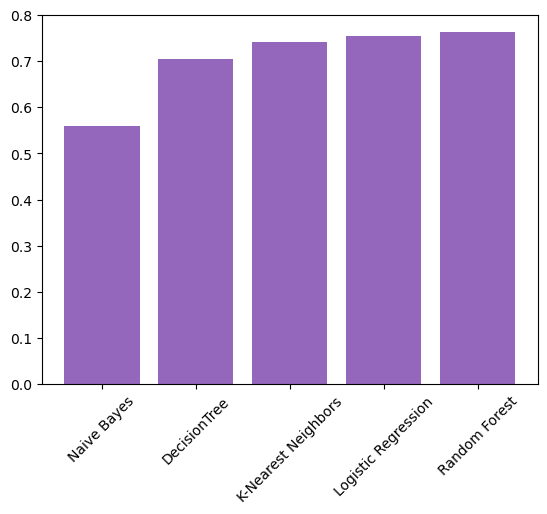

In [19]:
plt.bar(df_model['model'], df_model['accurcy'], color=color)
plt.xticks(rotation=45);

Random Forest is the best alghorithm

In [23]:
cf_matrix = confusion_matrix(y_test, y_pred)

print(cf_matrix)

[[1423  108]
 [ 409  236]]


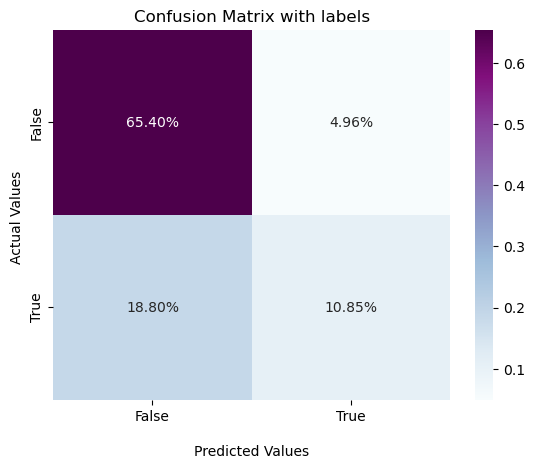

In [28]:
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap="BuPu")

ax.set_title('Confusion Matrix with labels');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()